In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import torch
import json


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# download subreddit embedding
!wget --output-document=/shared/0/projects/prosocial/data/finalized/subreddits/web-redditEmbeddings-subreddits.csv \
https://snap.stanford.edu/data/web-redditEmbeddings-subreddits.csv 

--2020-05-10 12:53:53--  https://snap.stanford.edu/data/web-redditEmbeddings-subreddits.csv
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144814301 (138M) [text/csv]
Saving to: ‘/shared/0/projects/prosocial/data/finalized/subreddits/web-redditEmbeddings-subreddits.csv’

/shared/0/projects/ 100%[===================>] 138.11M  33.4MB/s    in 5.6s    

2020-05-10 12:53:59 (24.5 MB/s) - ‘/shared/0/projects/prosocial/data/finalized/subreddits/web-redditEmbeddings-subreddits.csv’ saved [144814301/144814301]



In [3]:
vector_id = list(range(300))
header = ['Subreddit_ID'] + vector_id
df = pd.read_csv('/shared/0/projects/prosocial/data/finalized/subreddits/web-redditEmbeddings-subreddits.csv', names=header)

In [4]:
M = df[vector_id].values
pca = PCA(n_components=16)
pca.fit(M)
print(f"Explained variance : {pca.explained_variance_ratio_}")
print(f"Total Explained variance : {sum(pca.explained_variance_ratio_)}")

Explained variance : [0.16778141 0.10715389 0.09070878 0.05805875 0.04227539 0.03736818
 0.03690971 0.02893538 0.02465739 0.02227205 0.02180225 0.02009905
 0.01720723 0.016797   0.015455   0.01442191]
Total Explained variance : 0.7219033696098933


In [5]:
def single_plot_fig(labels, singluar_values, title, log=False):
    if log:
        singluar_values = np.log(singluar_values)
    data_zipped = [tuple(x) for x in zip(labels, singluar_values)]
    df = pd.DataFrame(data_zipped,
                  columns=["PC", "% variance explained"])
    sns.set(style="whitegrid")

    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 15))
    
    # Plot the total crashes
    sns.set_color_codes("pastel")
    sns.barplot(x="% variance explained", y="PC", data=df,
            label=title, ci=None)
    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel="converation outcomes", xlabel=title)
    sns.despine(left=True, bottom=True)

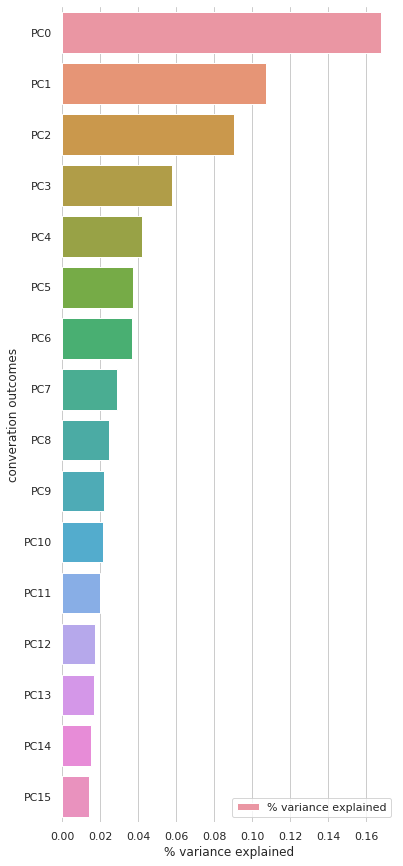

In [6]:
PC_labels = [f'PC{i}' for i in range(16)]
single_plot_fig(PC_labels, pca.explained_variance_ratio_, '% variance explained', False)

In [7]:
joblib.dump(pca, "/shared/0/projects/prosocial/data/finalized/subreddits/subreddits.pca.pth.tar")

['/shared/0/projects/prosocial/data/finalized/subreddits/subreddits.pca.pth.tar']

In [8]:
principle_embeddings = pca.transform(M)

In [9]:
principle_subreddit_embeddings_lookup = dict(zip(df['Subreddit_ID'].values, principle_embeddings))

In [10]:
print(f'mean: {principle_embeddings.mean()} std: {principle_embeddings.std()}')

mean: -6.096938330949804e-18 std: 0.49006673683348717


In [11]:
with open('/shared/0/projects/prosocial/data/finalized/subreddit_mappings.json', 'r') as istream:
    my_subreddits = json.load(istream)
print(f'number of subreddits embeddings we need: {len(my_subreddits)}')

number of subreddits embeddings we need: 11993


In [12]:
# ensure that there is no missing values
assert sorted(list(my_subreddits.values())) == sorted(list(range(11993)))

In [13]:
num_subreddit_embeddings = len(my_subreddits)
subreddit_embeddings_dim = 16

embeddings = torch.zeros((num_subreddit_embeddings, subreddit_embeddings_dim), dtype=torch.float32)

torch.manual_seed(42)
torch.nn.init.normal_(embeddings, mean=principle_embeddings.mean(), std=principle_embeddings.std())

used_subreddits = []
for k, v in my_subreddits.items():
    if k in principle_subreddit_embeddings_lookup:
        embeddings[v] = torch.from_numpy(principle_subreddit_embeddings_lookup[k]).to(torch.float32)
        used_subreddits.append(k)
print(f'used pretrained embeddings / total: {len(used_subreddits)} / {len(my_subreddits)}')


used pretrained embeddings / total: 5278 / 11993


In [14]:
torch.save(embeddings, 
           '/shared/0/projects/prosocial/data/finalized/subreddits/pretrained_subreddit_embeddings.tar.pth')